In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data = pd.read_csv('tic-tac-toe.data.txt', header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [5]:
X, y = data[np.arange(9)], np.array(data[9].values == 'positive',dtype=int)

Бинаризация фичей:

In [6]:
X_binarised = pd.concat([pd.get_dummies(X[col]) for col in X.columns],axis=1).values
assert X_binarised.shape == (X.shape[0], X.shape[1] * 3)

In [7]:
from sklearn.model_selection import ShuffleSplit

In [8]:
X_train,y_train = X_binarised, y

Выбор класса с помощью порога разности от взвешенных замыканий с положительным и отрицательным контекстом с кардинальностью больше константы 0.9, где итоговые скоры усредняются с весами, равными размеру общего контекста

In [114]:
def solve_with_closures(X_train, X_test, y_train, aggr, w_p):
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    pred = np.zeros(X_test.shape[0])
    for i,x in enumerate(X_test):
        inter_pos = (X_train_pos == x)
        inter_neg = (X_train_neg == x)
        closure_pos = np.array([(np.mean(x[context] == X_train_pos[:, context], axis=1) > 0.9) * np.sum(context)
                                for context in inter_pos])
        closure_neg = np.array([(np.mean(x[context] == X_train_neg[:, context], axis=1) > 0.9) * np.sum(context)
                                for context in inter_neg])
        score = lambda X: float(np.sum(X) / np.sum(np.ones(X.shape)))
        pred[i] = aggr(score(closure_pos), score(closure_neg)) > 0
    return pred

In [115]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

кросс-валидация

In [116]:
def cross_val_scores(X, y, calc_f):
    res = []
    for train_id, val_id in ShuffleSplit(n_splits=3, random_state=42).split(X, y):
        X_train, X_val = X_binarised[train_id], X_binarised[val_id]
        y_train, y_val = y[train_id], y[val_id]
        y_pred = calc_f(X_train, X_val, y_train)
        res.append([y_val, y_pred])
    return res

In [120]:
class Scorer:
    def __init__(self, fs, names):
        self.fs = fs
        self.names = names
    def score(self, Y_pairs):
        return np.array(list(np.mean(list(f(y_true=y1, y_pred=y2) for y1,y2 in Y_pairs)) for f in self.fs))
    def beauty_print(self, scores):
        for name,s in zip(self.names,scores):
            print('{0:}={1:.3f}'.format(name, s))

In [119]:
res = []
scorer = Scorer([accuracy_score, precision_score, recall_score, f1_score], ['accuracy', 'precision', 'recall', 'f1'])
l = np.linspace(0.7, 0.9, 10)
from tqdm import tqdm
for coef in tqdm(l, position=0):
    f = lambda a, b: a - coef * b
    Y = cross_val_scores(X, y, lambda X, X_t, y: solve_with_closures(X, X_t, y, f, w_p = w_p))
    res.append(scorer.score(Y))
res = np.array(res)

100%|██████████| 10/10 [02:55<00:00, 17.58s/it]


weight=1


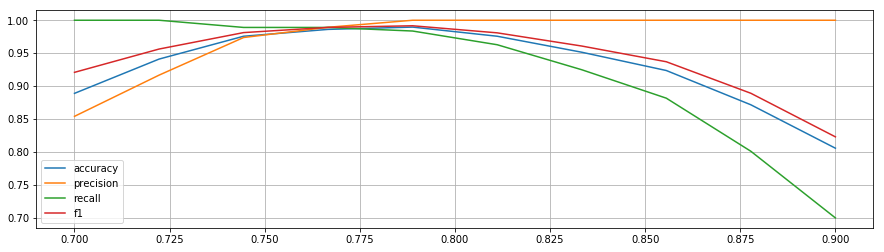

In [122]:
for res,w in zip(ress,W):
    print(f'weight={w}')
    plt.figure(figsize=(15,4))
    plt.plot(l, res[:, 0], label='accuracy')
    plt.plot(l, res[:, 1], label='precision')
    plt.plot(l, res[:, 2], label='recall')
    plt.plot(l, res[:, 3], label='f1')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

Лучшие значения метрик при максимальном F1:

In [123]:
arg = np.argmax(res[:, -1])
scorer.beauty_print(res[arg])

accuracy=0.990
precision=1.000
recall=0.984
f1=0.992


Random Forest для сравнения:

In [124]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
def solve_with_RF(X, X_t, y):
    clf = RandomForestClassifier()
    clf.fit(X, y)
    return clf.predict(X_t)

In [137]:
Y = cross_val_scores(X, y, solve_with_RF)
scorer.beauty_print(scorer.score(Y))

accuracy=0.983
precision=0.979
recall=0.995
f1=0.987
